In [1]:
import pandas as pd 
import numpy as np 
import cv2 
import imageio 
import wget 

In [2]:
#dowload the dataset 
wget.download("https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2017/04/a943287.csv")

100% [..............................................] 7847932 / 7847932

'a943287 (1).csv'

In [3]:
data = pd.read_csv('a943287.csv')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [4]:
#Fetch 1,000 male images and 1,000 female images from the URL links provided in the dataset:

data_male = data[data['please_select_the_gender_of_the_person_in_the_picture']=="male"].reset_index(drop='index')

data_female = data[data['please_select_the_gender_of_the_person_in_the_picture']=="female"].reset_index(drop='index')


final_data = pd.concat([data_male[:1000],data_female[:1000]],axis=0).reset_index(drop='index')


In [5]:
# final_data contains URL links for 1,000 male images and
# 1,000 female images. Read the URL links and fetch the images corresponding to
# the URL links. Ensure that all images are 300 × 300 × 3 in shape

x = []
y = []

for i in range(final_data.shape[0]):
    try:
        image = imageio.imread(final_data.loc[i]['image_url'])
        if(image.shape==(300,300,3)):
            x.append(image)
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
    
    except:
        continue

In [6]:
np.array(x).shape

(1748, 300, 300, 3)

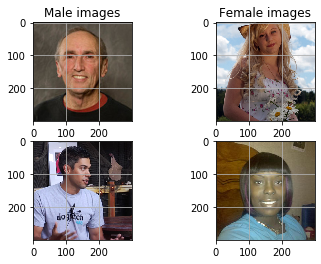

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(x[0])
plt.title('Male images')
plt.grid('off')
plt.subplot(222)
plt.title('Female images')
plt.imshow(x[1000])
plt.grid('off')
plt.subplot(223)
plt.imshow(x[1])
plt.grid('off')
plt.subplot(224)
plt.imshow(x[1001])
plt.grid('off')
plt.show()

***

#### TRANSFER LEARNING WITH VGG19 

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Use a pre-trained model VGG19 and fine tune it's output (linking it to another convolution layer, flatten it and link it
# to a sigmoid activation function in the final layer) -> transfering the learning from an architecture,
# and make sure to freeze the weights update while training your model on images. 
# we used the VGG19 architecture to pre-process inputs (images, by using the model to predict features of images) -> use 
# those features in a subsequent built model. 

# Import the pre-trained model:
from keras.applications import vgg19
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import preprocess_input
vgg19_MODEL = vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(300,300,3))


# we are excluding the last layer in the VGG19 model. This is to ensure
# that we fine-tune the VGG19 model for the problem that we are trying solve.
# Additionally, given that our input image shape is 300 X 300 X 3, we are specifying
# the same while downloading the VGG19 model.

In [12]:
vgg19_MODEL.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [20]:
# We will pass each image through vgg19_MODEL so that we take the output
# of vgg19_MODEL as the processed input. Additionally, we will be performing the
# preprocessing on top of the input as follows:

x_vgg19 = []
for i in range(len(x)):
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))

#Now, we pass the pre-processed input to the VGG19 model to extract features, as
# follows:

    img_new = vgg19_MODEL.predict(img.reshape(1,300,300,3))

    x_vgg19.append(img_new)

#In the preceding code, in addition to passing the image through VGG19 model,
#we have also stored the input values in a list.

In [21]:
# one hot encoding of labels 
Y = []
for i in range(len(y)):
    img_label = np.where(y[i]=="male",1,0)
    Y.append(img_label)
Y = np.array(Y)

In [22]:
# Convert the input and output to NumPy arrays and create training and test sets:
x_vgg19 = np.array(x_vgg19)

x_vgg19= x_vgg19.reshape(x_vgg19.shape[0],x_vgg19.shape[2],x_vgg19.shape[3],x_vgg19.shape[4])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_vgg19, Y, test_size=0.1, random_state=42)

In [23]:
X_train.shape

(1573, 9, 9, 512)

In [24]:
y_train.shape

(1573,)

In [109]:
#Build and compile the model:

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

model_vgg19 = Sequential()

model_vgg19.add(Conv2D(512, kernel_size=(3, 3),
                       activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))

model_vgg19.add(MaxPooling2D(pool_size=(2, 2)))

model_vgg19.add(Flatten())

model_vgg19.add(Dense(512, activation='relu'))

model_vgg19.add(Dropout(0.20))

model_vgg19.add(Dense(1, activation='sigmoid'))

model_vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
_________________________________________________________________


In [110]:
#Compile the model:
model_vgg19.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [111]:
##### Fit the model while scaling the input data:
history_vgg19 = model_vgg19.fit(X_train/np.max(X_train), 
                                y_train,batch_size=350,epochs=3,verbose=2,
                                validation_data =(X_test/np.max(X_train), y_test))

Train on 1573 samples, validate on 175 samples
Epoch 1/3
 - 33s - loss: 0.6439 - acc: 0.6885 - val_loss: 0.5046 - val_acc: 0.8571
Epoch 2/3
 - 29s - loss: 0.3980 - acc: 0.8849 - val_loss: 0.3525 - val_acc: 0.8629
Epoch 3/3
 - 28s - loss: 0.2174 - acc: 0.9218 - val_loss: 0.3381 - val_acc: 0.8857


In [114]:
mypic = imageio.imread('abbas.jpg')
mypic.shape

(812, 623, 3)

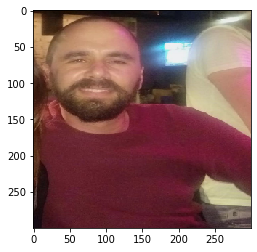

In [117]:
mypic = cv2.resize(mypic,(300,300))
plt.imshow(mypic)

In [118]:
# my rezied pic pass through the VGG19 first to extract features and pass through the compiled model for prediction 

model_vgg19.predict(vgg19_MODEL.predict(preprocess_input(mypic.reshape(1,300,300,3)))/np.max(X_train))

array([[0.7678929]], dtype=float32)

In [119]:
for layer in vgg19_MODEL.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [120]:
# build an intermediate model named inter_model, pass the image of interest as input and its output will be the first
# convolutional layer

# After the intermediate model is defined -> pass the reshaped image of interest as input and the output will be the first
# convolutional layer 

from keras import models
inter_model = models.Model(inputs=vgg19_MODEL.input,outputs=vgg19_MODEL.layers[1].output)
inter = inter_model.predict(preprocess_input(mypic.reshape(1,300,300,3)))

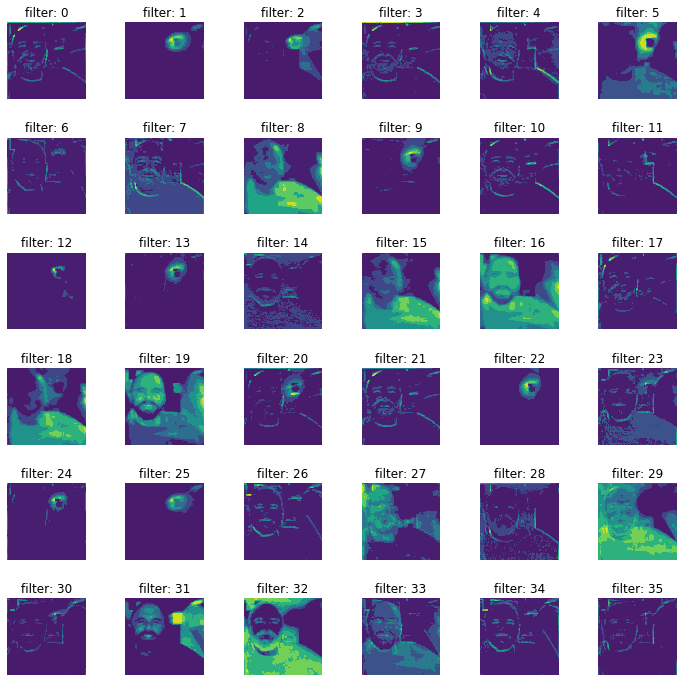

In [122]:
fig, axs = plt.subplots(6, 6, figsize=(12, 12))
fig.subplots_adjust(hspace = .5, wspace=.5)
first_layer_activation = inter[0]
for i in range(6):
    for j in range(6):
        try:
            axs[i,j].set_ylim((224, 0))
            axs[i,j].contourf(first_layer_activation[:,:,((6*i)+j)],6,cmap='viridis')
            axs[i,j].set_title('filter: '+str((6*i)+j))
            axs[i,j].axis('off')
        except:
              continue

In [34]:
history_dict = history_vgg19.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

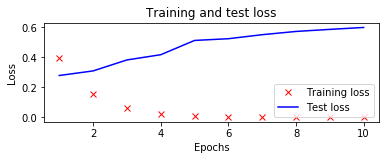

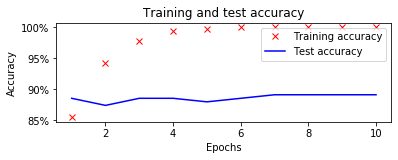

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, history_vgg19.history['loss'],'rx',label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.subplot(212)
plt.plot(epochs, history_vgg19.history['acc'], 'rx', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.show()